In [1]:
from pathlib import Path
import os
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from scipy.integrate import solve_ivp
from scipy.optimize import minimize

from sklearn.metrics import mean_squared_log_error, mean_squared_error

from pmdarima.arima import auto_arima

/usr/local/anaconda3/envs/ml_project/lib/python3.7/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/anaconda3/envs/ml_project/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
app_dir = '/Users/paramshah/Documents/Param/NYU/courses/Machine Learning/Project/Github Team/covid-19'

In [3]:
_type = 'cases'

In [4]:
df = pd.read_csv(os.path.join(app_dir, f'data/staging/jhu_{_type}.csv'))
df['date'] = pd.to_datetime(df['date'])

In [5]:
countries = df.country.unique()

In [6]:
for country in countries:
    print(country)

United States
India
Italy
Canada
Spain
France
United Kingdom
Iraq
Japan
Germany
Brazil


In [7]:
df[(df['country'] == "United States") & (df[_type] != 0)]

,country,date,cases,cases_lag_1,cases_lag_2,cases_lag_3,cases_lag_4,cases_lag_5,cases_lag_6,cases_lag_7,...,cases_lag_10,cases_lag_11,cases_lag_12,cases_lag_13,cases_lag_14,cases_lag_15,cases_lag_16,cases_lag_17,cases_lag_18,cases_lag_19
0,United States,2020-01-22,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,United States,2020-01-23,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,United States,2020-01-24,2,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,United States,2020-01-25,2,2,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,United States,2020-01-26,5,2,2,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,United States,2020-05-10,1329260,1309550,1283929,1257023,1229331,1204351,1180375,1158040,...,1069424,1039909,1012582,988197,965785,938154,905358,869170,840351,811865
110,United States,2020-05-11,1347881,1329260,1309550,1283929,1257023,1229331,1204351,1180375,...,1103461,1069424,1039909,1012582,988197,965785,938154,905358,869170,840351
111,United States,2020-05-12,1369376,1347881,1329260,1309550,1283929,1257023,1229331,1204351,...,1132539,1103461,1069424,1039909,1012582,988197,965785,938154,905358,869170
112,United States,2020-05-13,1390406,1369376,1347881,1329260,1309550,1283929,1257023,1229331,...,1158040,1132539,1103461,1069424,1039909,1012582,988197,965785,938154,905358


In [8]:
df['date'].unique()

array(['2020-01-22T00:00:00.000000000', '2020-01-23T00:00:00.000000000',
       '2020-01-24T00:00:00.000000000', '2020-01-25T00:00:00.000000000',
       '2020-01-26T00:00:00.000000000', '2020-01-27T00:00:00.000000000',
       '2020-01-28T00:00:00.000000000', '2020-01-29T00:00:00.000000000',
       '2020-01-30T00:00:00.000000000', '2020-01-31T00:00:00.000000000',
       '2020-02-01T00:00:00.000000000', '2020-02-02T00:00:00.000000000',
       '2020-02-03T00:00:00.000000000', '2020-02-04T00:00:00.000000000',
       '2020-02-05T00:00:00.000000000', '2020-02-06T00:00:00.000000000',
       '2020-02-07T00:00:00.000000000', '2020-02-08T00:00:00.000000000',
       '2020-02-09T00:00:00.000000000', '2020-02-10T00:00:00.000000000',
       '2020-02-11T00:00:00.000000000', '2020-02-12T00:00:00.000000000',
       '2020-02-13T00:00:00.000000000', '2020-02-14T00:00:00.000000000',
       '2020-02-15T00:00:00.000000000', '2020-02-16T00:00:00.000000000',
       '2020-02-17T00:00:00.000000000', '2020-02-18

In [9]:
dates = df[(df['date'] >= '2020-02-15') & (df['date'] <= '2020-05-09')]['date'].unique()

In [10]:
n_periods = 10
column_names = ["country", "date"]

for i in range(n_periods):
    column_names.append(f"date+{i+1}_pred")
for i in range(n_periods):
    column_names.append(f"date+{i+1}_linf")
for i in range(n_periods):
    column_names.append(f"date+{i+1}_lsup")

In [11]:
column_names

['country',
 'date',
 'date+1_pred',
 'date+2_pred',
 'date+3_pred',
 'date+4_pred',
 'date+5_pred',
 'date+6_pred',
 'date+7_pred',
 'date+8_pred',
 'date+9_pred',
 'date+10_pred',
 'date+1_linf',
 'date+2_linf',
 'date+3_linf',
 'date+4_linf',
 'date+5_linf',
 'date+6_linf',
 'date+7_linf',
 'date+8_linf',
 'date+9_linf',
 'date+10_linf',
 'date+1_lsup',
 'date+2_lsup',
 'date+3_lsup',
 'date+4_lsup',
 'date+5_lsup',
 'date+6_lsup',
 'date+7_lsup',
 'date+8_lsup',
 'date+9_lsup',
 'date+10_lsup']

In [12]:
# column_names = [
#     "country", "date", 
#     "date+1_pred",
#     "date+2_pred",
#     "date+3_pred",
#     "date+4_pred",
#     "date+5_pred",
#     "date+6_pred",
#     "date+7_pred",
#     "date+8_pred",
#     "date+9_pred",
#     "date+10_pred",
#     "date+1_linf",
#     "date+2_linf",
#     "date+3_linf",
#     "date+4_linf",
#     "date+5_linf",
#     "date+6_linf",
#     "date+7_linf",
#     "date+8_linf",
#     "date+9_linf",
#     "date+10_linf",
#     "date+1_lsup",
#     "date+2_lsup",
#     "date+3_lsup",
#     "date+4_lsup",
#     "date+5_lsup",
#     "date+6_lsup",
#     "date+7_lsup",
#     "date+8_lsup",
#     "date+9_lsup",
#     "date+10_lsup"
# ]
df_preds = pd.DataFrame(columns = column_names)

In [20]:
predictions = {}

countries = list(countries)
i = 0
for country in ["Brazil"]:
    predictions[country] = {}
#     if country != 'Canada':
#         print(country)
    for date in dates:
        data_for_prediction = df[(df['country'] == country) & (df['date'] <= date)]
        cases = data_for_prediction.sort_values(by=['date'])[_type].dropna().values
        try:
            model = auto_arima(cases, start_p=0, start_q=0,
                                  test='adf',       # use adftest to find optimal 'd'
                                  max_p=12, max_q=12, # maximum p and q
                                  m=1,              # frequency of series
                                  d=None,           # let model determine 'd'
                                  seasonal=False,   # No Seasonality
                                  start_P=0, 
                                  D=0, with_intercept=False,
                                  trace=False,
                                  error_action='ignore',  
                                  suppress_warnings=True, 
                                  stepwise=True)
        except:
            print(f"Did not work for {country} at date {date}")
            continue

        fc, confint = model.predict(n_periods=n_periods, return_conf_int=True,alpha=0.2)
        # make series for plotting purpose
        fc = pd.DataFrame(fc,columns = ['Prediction'])

        lower_series = pd.DataFrame(confint[:, 0],columns = ['Linf'])
        upper_series = pd.DataFrame(confint[:, 1],columns = ['Lsup'])

        date2 = data_for_prediction['date'][-n_periods:] + pd.DateOffset(days=n_periods)
        try_df = pd.DataFrame({'index':date2.index, 'date':date2.values})

        fc=pd.concat([fc,lower_series,upper_series,try_df['date']],axis=1)
        fc.set_index([ 'date'], inplace=True)

        train = data_for_prediction.copy()
        train.set_index(['date'], inplace=True)
        train=train.dropna()

        actual = df[(df['country'] == country) & (df['date'] >= date2.values[0]) & (df['date'] <= date2.values[-1])]
        actual = actual.set_index(['date'])

        predictions[country][date] = {}
        predictions[country][date]['dates'] = fc.index.values
        predictions[country][date]['Predictions'] = fc.Prediction.values
        predictions[country][date]['Linfs'] = fc.Linf.values
        predictions[country][date]['Lsups'] = fc.Lsup.values
        predictions[country][date]['actuals'] = actual[_type].values
        
        df_preds.loc[i] = [country, date] + list(fc.Prediction.values) + list(fc.Linf.values) + list(fc.Lsup.values)
        i+=1

/usr/local/anaconda3/envs/ml_project/lib/python3.7/site-packages/pmdarima/arima/auto.py:253: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/usr/local/anaconda3/envs/ml_project/lib/python3.7/site-packages/pmdarima/arima/auto.py:253: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/usr/local/anaconda3/envs/ml_project/lib/python3.7/site-packages/pmdarima/arima/auto.py:253: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/usr/local/anaconda3/envs/ml_project/lib/python3.7/site-packages/pmdarima/arima/auto.py:253: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/usr/local/anaconda3/envs/ml_project/lib/python3.7/s

Did not work for Brazil at date 2020-02-15T00:00:00.000000000
Did not work for Brazil at date 2020-02-16T00:00:00.000000000
Did not work for Brazil at date 2020-02-17T00:00:00.000000000
Did not work for Brazil at date 2020-02-18T00:00:00.000000000
Did not work for Brazil at date 2020-02-19T00:00:00.000000000
Did not work for Brazil at date 2020-02-20T00:00:00.000000000
Did not work for Brazil at date 2020-02-21T00:00:00.000000000
Did not work for Brazil at date 2020-02-22T00:00:00.000000000
Did not work for Brazil at date 2020-02-23T00:00:00.000000000
Did not work for Brazil at date 2020-02-24T00:00:00.000000000
Did not work for Brazil at date 2020-02-25T00:00:00.000000000
Did not work for Brazil at date 2020-02-26T00:00:00.000000000
Did not work for Brazil at date 2020-02-27T00:00:00.000000000
Did not work for Brazil at date 2020-02-28T00:00:00.000000000


In [24]:
predictions

{'Brazil': {numpy.datetime64('2020-02-29T00:00:00.000000000'): {'dates': array(['2020-03-01T00:00:00.000000000', '2020-03-02T00:00:00.000000000',
          '2020-03-03T00:00:00.000000000', '2020-03-04T00:00:00.000000000',
          '2020-03-05T00:00:00.000000000', '2020-03-06T00:00:00.000000000',
          '2020-03-07T00:00:00.000000000', '2020-03-08T00:00:00.000000000',
          '2020-03-09T00:00:00.000000000', '2020-03-10T00:00:00.000000000'],
         dtype='datetime64[ns]'),
   'Predictions': array([1.95159079, 1.9043533 , 1.85825918, 1.81328074, 1.769391  ,
          1.72656358, 1.68477279, 1.64399353, 1.60420131, 1.56537225]),
   'Linfs': array([1.65775927, 1.49381097, 1.36144777, 1.24639918, 1.14303375,
          1.04840568, 0.96072774, 0.87880909, 0.80180286, 0.72907715]),
   'Lsups': array([2.24542231, 2.31489562, 2.35507058, 2.3801623 , 2.39574825,
          2.40472149, 2.40881784, 2.40917797, 2.40659976, 2.40166735]),
   'actuals': array([ 2,  2,  2,  4,  4, 13, 13, 20, 25,

In [25]:
df_preds.tail(10)

,country,date,date+1_pred,date+2_pred,date+3_pred,date+4_pred,date+5_pred,date+6_pred,date+7_pred,date+8_pred,...,date+1_lsup,date+2_lsup,date+3_lsup,date+4_lsup,date+5_lsup,date+6_lsup,date+7_lsup,date+8_lsup,date+9_lsup,date+10_lsup
899,Brazil,2020-04-30,94549.136785,101929.868360,109308.127761,116686.715838,124065.260216,131443.810405,138822.359821,146200.909340,...,95101.776410,103100.352871,111227.160210,119464.531706,127799.855213,136224.111569,144730.353559,153313.040133,161967.617022,170690.256001
900,Brazil,2020-05-01,97804.486595,103406.973190,109009.459784,114611.946379,120214.432974,125816.919569,131419.406163,137021.892758,...,98426.951522,104646.273860,110971.275239,117392.150138,123899.784316,130486.938175,137147.828279,143877.734218,150672.721390,157529.450072
901,Brazil,2020-05-02,102125.246229,107150.492457,112175.738686,117200.984914,122226.231143,127251.477372,132276.723600,137301.969829,...,102750.283750,108429.505117,114229.386375,120136.512571,126139.963269,132231.363193,138404.127451,144652.929561,150973.355098,157361.671859
902,Brazil,2020-05-03,106608.968711,111391.937422,116174.906133,120957.874844,125740.843554,130523.812265,135306.780976,140089.749687,...,107232.036160,112674.930289,118241.431663,123917.357750,129691.420656,135555.019244,141501.411439,147525.153038,153621.737070,159787.356052
903,Brazil,2020-05-04,114996.689454,121223.299612,127395.936066,133549.161710,139695.406557,145839.140867,151981.972302,158124.479031,...,115658.124741,122553.668699,129466.423607,136425.737937,143441.391160,150515.506649,157647.288829,164834.920160,172076.311583,179369.391432
904,Brazil,2020-05-05,122046.517356,128541.623003,134998.552549,141440.365522,147876.192792,154309.649907,160742.168513,167174.315497,...,122707.082464,129884.738015,137101.589343,144372.581934,151702.975340,159093.575163,166543.249842,174050.116974,181612.080350,189227.062499
905,Brazil,2020-05-06,136158.583759,146381.568998,154460.113709,162316.532328,169987.043628,178214.873389,187073.787555,196076.439144,...,136941.467841,147986.655219,157217.555909,166180.215285,174943.717823,184224.890367,194165.617092,204338.946225,214595.678973,224579.414532
906,Brazil,2020-05-07,146414.820015,155540.766847,164826.684180,174112.601512,183398.518845,192684.436178,201970.353510,211256.270843,...,147219.855648,157165.652171,167646.186674,178171.788727,188781.948370,199483.066456,210274.329847,221152.942153,232115.625661,243159.119018
907,Brazil,2020-05-08,156434.533901,166274.073667,175993.274294,185712.474921,195431.675548,205150.876176,214870.076803,224589.277430,...,157237.253086,167894.516979,178827.302916,189818.484298,200903.735306,212087.655713,223368.344111,234742.265453,246205.603054,257754.681873
908,Brazil,2020-05-09,166443.019270,176303.233693,186921.845166,197106.065760,207350.893889,217266.852475,227351.827286,237499.856285,...,167197.059473,177788.371207,189559.404780,200933.274801,212445.487788,223623.209568,235073.230269,246712.888822,258664.152936,270629.249730


In [15]:
df_preds.to_csv('arima_data2.csv', index=False)

In [16]:
for key, val in predictions.items():
    print(key)

United States
India
Italy
Canada
Spain
France
United Kingdom
Iraq
Japan
Germany
Brazil


In [22]:
fc

,Prediction,Linf,Lsup
date,,,
2020-05-10,166443.019270,165688.979066,167197.059473
2020-05-11,176303.233693,174818.096179,177788.371207
2020-05-12,186921.845166,184284.285552,189559.404780
2020-05-13,197106.065760,193278.856718,200933.274801
2020-05-14,207350.893889,202256.299989,212445.487788
2020-05-15,217266.852475,210910.495382,223623.209568
2020-05-16,227351.827286,219630.424304,235073.230269
2020-05-17,237499.856285,228286.823748,246712.888822
2020-05-18,247811.424830,236958.696724,258664.152936


In [23]:
actual

,country,cases,cases_lag_1,cases_lag_2,cases_lag_3,cases_lag_4,cases_lag_5,cases_lag_6,cases_lag_7,cases_lag_8,...,cases_lag_10,cases_lag_11,cases_lag_12,cases_lag_13,cases_lag_14,cases_lag_15,cases_lag_16,cases_lag_17,cases_lag_18,cases_lag_19
date,,,,,,,,,,,,,,,,,,,,,
2020-05-10,Brazil,162699,156061,146894,135773,126611,115455,108620,101826,97100,...,87187,79685,73235,67446,63100,59324,54043,50036,45757,43079
2020-05-11,Brazil,169594,162699,156061,146894,135773,126611,115455,108620,101826,...,92202,87187,79685,73235,67446,63100,59324,54043,50036,45757
2020-05-12,Brazil,178214,169594,162699,156061,146894,135773,126611,115455,108620,...,97100,92202,87187,79685,73235,67446,63100,59324,54043,50036
2020-05-13,Brazil,190137,178214,169594,162699,156061,146894,135773,126611,115455,...,101826,97100,92202,87187,79685,73235,67446,63100,59324,54043
2020-05-14,Brazil,203165,190137,178214,169594,162699,156061,146894,135773,126611,...,108620,101826,97100,92202,87187,79685,73235,67446,63100,59324


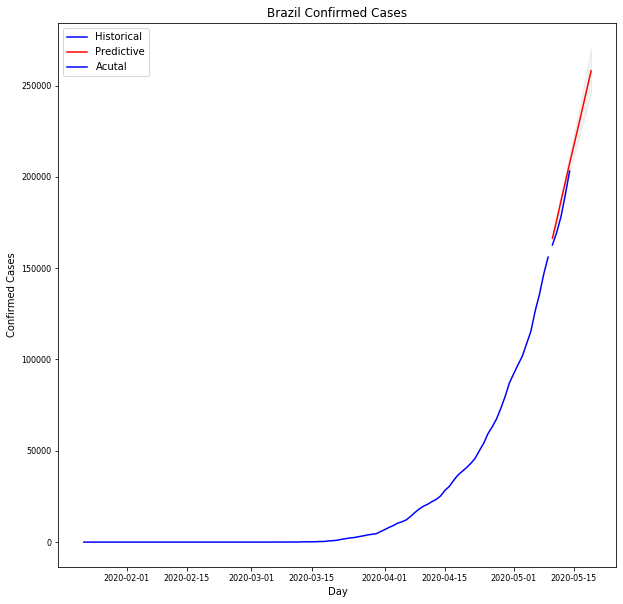

In [26]:
# Plot
plt.figure(figsize=(10,10))

plt.title(f'{country} Confirmed Cases')
plt.plot(train[_type],label='Historical',color='blue')
plt.plot(fc.Prediction,label='Predictive',color='red')
plt.plot(actual[_type],label='Acutal',color='blue')
plt.fill_between(fc.index, 
                 fc.Linf, 
                 fc.Lsup, 
                 color='k', alpha=.05)
plt.xlabel('Day',fontsize=10)
plt.ylabel('Confirmed Cases',fontsize=10)
plt.xticks(rotation=0,fontsize=8)
plt.yticks(fontsize=8)
# plt.yscale('log')
plt.legend()


plt.show()